In [1]:
%matplotlib inline

import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.model_selection import train_test_split

# https://discuss.pytorch.org/t/output-of-resnet34-network-depends-on-the-batch-size/21647
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
np.random.seed(0)

In [2]:
n_epocs = 10000
epochs_per_stats = 1
batch_size = 4096
test_size = 0.2
learning_rate = 0.002 * (batch_size / 1024.0)
momentum = 0.0

WORKING_DIR = '/home/richard/Downloads/nn/PSU_back/'

In [3]:
with open('/home/richard/data/connect4/7ply_boards.pkl', 'rb') as f:
    boards = pickle.load(f)
with open ('/home/richard/data/connect4/7ply_values.pkl', 'rb') as f:
    values = pickle.load(f)

board_train, board_test, value_train, value_test = train_test_split(boards, values, test_size=test_size, shuffle=True)

In [4]:
from connect4.neural.nn_pytorch import Connect4Dataset

train = Connect4Dataset(board_train, value_train, to_move_channel=False)
test = Connect4Dataset(board_test, value_test, to_move_channel=False)

train_gen = data.DataLoader(train, batch_size, shuffle=True)
test_gen = data.DataLoader(test, 4096, shuffle=False)

Creating dataset with 22391 positions
Creating dataset with 5598 positions


In [5]:
from connect4.neural.nn_pytorch import build_value_net

# net = build_value_net(64, value_head_fc_layers=16)
net = build_value_net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (1): Sequential(
    (0): ResidualLayer(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): ResidualLayer(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0

In [6]:
criterion = nn.MSELoss()
# criterion = nn.L1Loss(reduction='none')

# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(net.parameters())

In [7]:
# option to load previous progress
# file_path = WORKING_DIR + '../nn9.pth'
# file_path = '/home/richard/Downloads/nn/8-1.pth'
file_path = None
if file_path is not None:
    checkpoint = torch.load(file_path)
    net.load_state_dict(checkpoint['net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [8]:
from connect4.neural.stats import Stats

# Get an idea of how the initialisation is
def evaluate_fit(net, test_gen, device, output_stats=False):
    test_stats = Stats() if output_stats else None
    with torch.set_grad_enabled(False):
        net = net.eval()
        net.train(False)
        for board, value in test_gen:
            board, value = board.to(device), value.to(device)

            output = net(board)
#             output = output.view(-1)
            assert output.shape == value.shape
            
            loss = criterion(output, value)
#             print(output.shape, value.shape)
#             print(output, value, loss)

            if output_stats:
                output = output.cpu().numpy().flatten()
                value = value.cpu().numpy().flatten()
                test_stats.update(output, value, loss)
    return test_stats

test_stats = evaluate_fit(net, test_gen, device, True)
print("Initial Test Stats:\n", test_stats)

Initial Test Stats:
 Average loss:  0.22359  Accuracy:  0.11933  Smallest:  0.45189  Largest:  0.45337  Average:  0.45273
Category, # Members, # Correct Predictions:  (0.0, 2398, 0)  (0.5, 668, 668)  (1.0, 2532, 0)


Epoch:   0 
Train:
 Average loss:  0.21351  Accuracy:  0.11697  Smallest:  0.43786  Largest:  0.61889  Average:  0.48066
Category, # Members, # Correct Predictions:  (0.0, 9903, 0)  (0.5, 2619, 2619)  (1.0, 9869, 0) 
Test:
 Average loss:  0.22105  Accuracy:  0.11933  Smallest:  0.47924  Largest:  0.48075  Average:  0.47976
Category, # Members, # Correct Predictions:  (0.0, 2398, 0)  (0.5, 668, 668)  (1.0, 2532, 0)


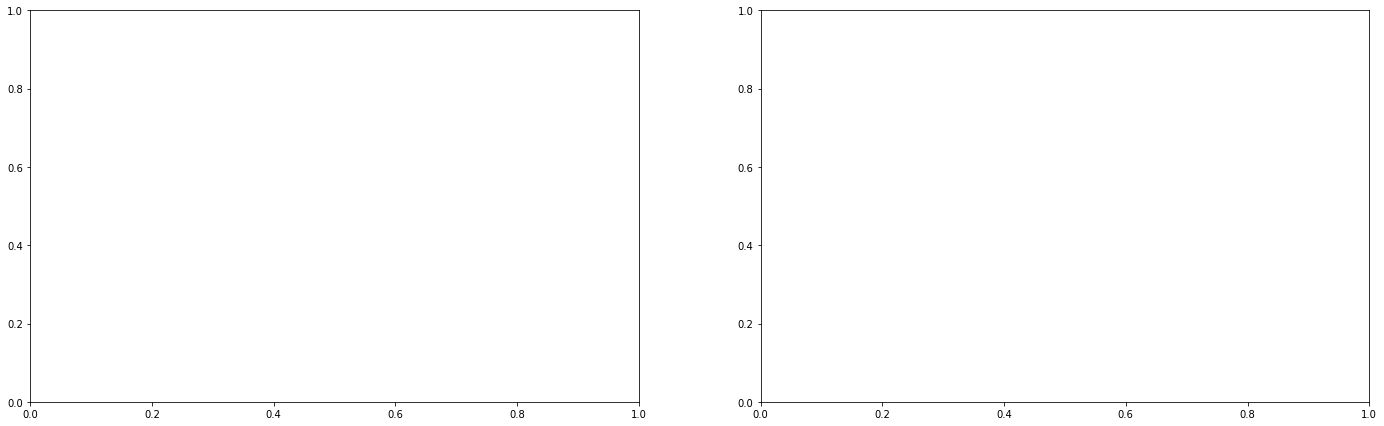

Epoch:   1 
Train:
 Average loss:  0.18141  Accuracy:  0.17851  Smallest:  0.36680  Largest:  0.83726  Average:  0.51837
Category, # Members, # Correct Predictions:  (0.0, 9903, 0)  (0.5, 2619, 2613)  (1.0, 9869, 1384) 
Test:
 Average loss:  0.22140  Accuracy:  0.11933  Smallest:  0.47469  Largest:  0.47532  Average:  0.47478
Category, # Members, # Correct Predictions:  (0.0, 2398, 0)  (0.5, 668, 668)  (1.0, 2532, 0)
Epoch:   2 
Train:
 Average loss:  0.14024  Accuracy:  0.37680  Smallest:  0.23443  Largest:  0.94827  Average:  0.53961
Category, # Members, # Correct Predictions:  (0.0, 9903, 630)  (0.5, 2619, 2319)  (1.0, 9869, 5488) 
Test:
 Average loss:  0.22234  Accuracy:  0.11933  Smallest:  0.46332  Largest:  0.46582  Average:  0.46357
Category, # Members, # Correct Predictions:  (0.0, 2398, 0)  (0.5, 668, 668)  (1.0, 2532, 0)
Epoch:   3 
Train:
 Average loss:  0.10018  Accuracy:  0.69148  Smallest:  0.03789  Largest:  0.98053  Average:  0.52778
Category, # Members, # Correct Pred

Epoch:   21 
Train:
 Average loss:  0.02795  Accuracy:  0.89072  Smallest:  0.00000  Largest:  0.99999  Average:  0.50012
Category, # Members, # Correct Predictions:  (0.0, 9903, 9514)  (0.5, 2619, 908)  (1.0, 9869, 9522) 
Test:
 Average loss:  0.05518  Accuracy:  0.81994  Smallest:  0.00000  Largest:  0.99998  Average:  0.49421
Category, # Members, # Correct Predictions:  (0.0, 2398, 2180)  (0.5, 668, 181)  (1.0, 2532, 2229)
Epoch:   22 
Train:
 Average loss:  0.02937  Accuracy:  0.88245  Smallest:  0.00000  Largest:  1.00000  Average:  0.49979
Category, # Members, # Correct Predictions:  (0.0, 9903, 9498)  (0.5, 2619, 793)  (1.0, 9869, 9468) 
Test:
 Average loss:  0.05688  Accuracy:  0.81743  Smallest:  0.00001  Largest:  0.99998  Average:  0.54202
Category, # Members, # Correct Predictions:  (0.0, 2398, 2041)  (0.5, 668, 183)  (1.0, 2532, 2352)
Epoch:   23 
Train:
 Average loss:  0.02807  Accuracy:  0.88710  Smallest:  0.00000  Largest:  1.00000  Average:  0.49353
Category, # Member

Epoch:   41 
Train:
 Average loss:  0.01561  Accuracy:  0.92997  Smallest:  0.00000  Largest:  1.00000  Average:  0.49584
Category, # Members, # Correct Predictions:  (0.0, 9903, 9808)  (0.5, 2619, 1241)  (1.0, 9869, 9774) 
Test:
 Average loss:  0.05490  Accuracy:  0.82440  Smallest:  0.00000  Largest:  1.00000  Average:  0.52414
Category, # Members, # Correct Predictions:  (0.0, 2398, 2137)  (0.5, 668, 135)  (1.0, 2532, 2343)
Epoch:   42 
Train:
 Average loss:  0.01519  Accuracy:  0.93189  Smallest:  0.00000  Largest:  1.00000  Average:  0.50205
Category, # Members, # Correct Predictions:  (0.0, 9903, 9807)  (0.5, 2619, 1269)  (1.0, 9869, 9790) 
Test:
 Average loss:  0.05469  Accuracy:  0.83065  Smallest:  0.00000  Largest:  1.00000  Average:  0.50339
Category, # Members, # Correct Predictions:  (0.0, 2398, 2183)  (0.5, 668, 157)  (1.0, 2532, 2310)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [9]:
%%time

from laplotter import LossAccPlotter
from visdom import Visdom

viz = Visdom()
plotter = LossAccPlotter(show_regressions=False, show_averages=False)

for epoch in range(n_epocs):
    
    net = net.train()
    train_stats = Stats()
    
    for board, value in train_gen:
        board, value = board.to(device), value.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(board)
#         output = output.view(-1)
        assert output.shape == value.shape
            
        loss = criterion(output, value)
        loss.backward()
        optimizer.step()
        
        if epoch % epochs_per_stats == 0:
            output = output.cpu().view(-1).detach().numpy()
            value = value.cpu().view(-1).numpy()
            train_stats.update(output, value, loss)

    # validate
    test_stats = evaluate_fit(net, test_gen, device, epoch % epochs_per_stats == 0)
                
    if test_stats is not None:            
        print("Epoch:  ", epoch, "\nTrain:\n", train_stats, "\nTest:\n", test_stats)
        plotter.add_values(epoch,
                           loss_train=train_stats.loss, acc_train=train_stats.accuracy,
                           loss_val=test_stats.loss, acc_val=test_stats.accuracy)
        if epoch == 0:
            win = viz.matplot(plotter.fig)
        else:
            viz.matplot(plotter.fig, win=win)
        
    torch.save({
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        WORKING_DIR + str(epoch) + '-' + str(batch_size) + '.pth')
            
print('Finished Training')

In [10]:
plotter.fig

NameError: name 'plotter' is not defined